In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from datetime import datetime
%matplotlib widget

['QQQ', '2021-01-01', '2021-12-01', '1d']
1.8779708107078548x+1.5392400167054276±0.6606316709339621
['QQQ', '2022-01-01', '2022-12-01', '1h']
1.2906289534603663x+-1.3132109883851608±0.9233877129226148
['QQQ', '2023-01-01', '2023-12-01', '1h']
1.5592949648021015x+1.5755903934242337±0.3381550525914864


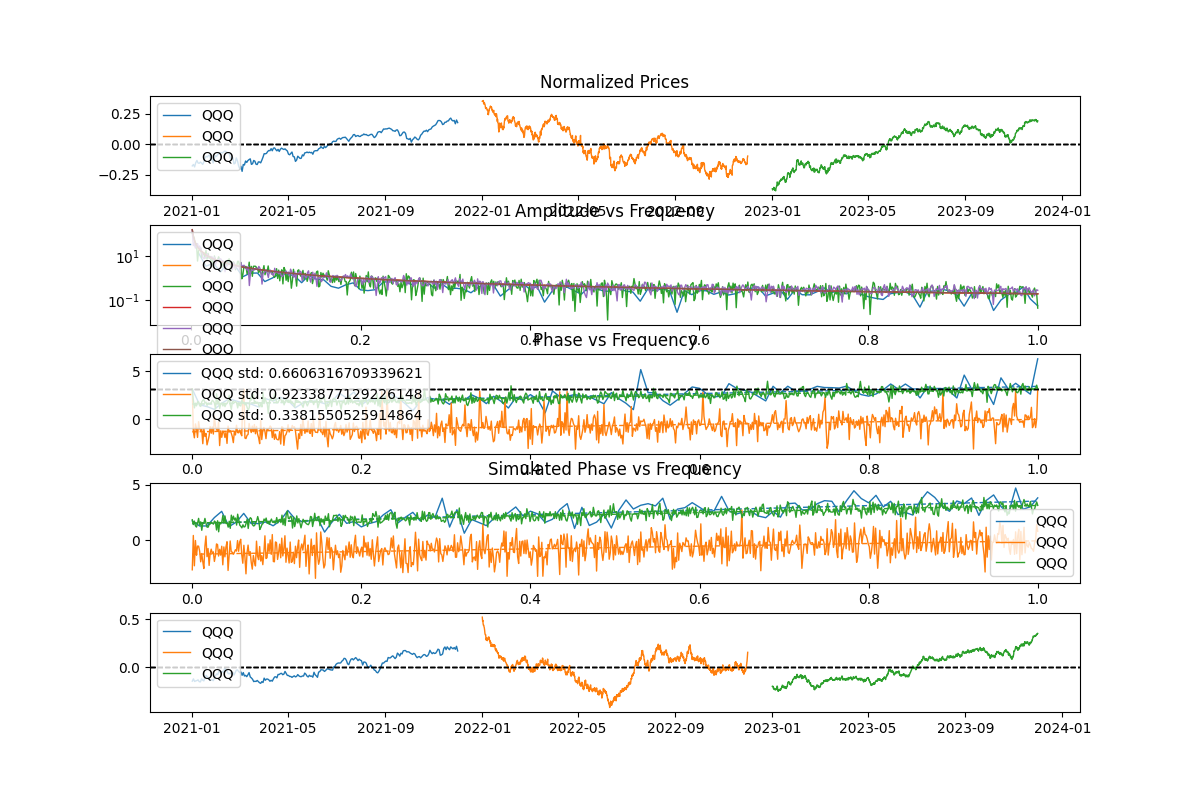

In [3]:
plt.figure(figsize=(12, 8))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

tickers = [
    ['QQQ', '2021-01-01', '2021-12-01', '1d'],
    ['QQQ', '2022-01-01', '2022-12-01', '1h'],
    ['QQQ', '2023-01-01', '2023-12-01', '1h'],
    # ['QQQ', '2016-01-01', '2016-12-01', '1d'],
    # ['VOO', '2023-03-01', '2023-06-01', '1h'],
    # ['O', '2015-01-01', '2015-12-01', '1d'],
    # ['O', '2023-01-01', '2023-12-01', '1h'],
    # ['O', '2023-09-01', '2023-12-01', '1h'],
]
for ticker in tickers:
    print(ticker)
    prices = np.array(yf.Ticker(ticker[0]).history(start=ticker[1], end=ticker[2], interval=ticker[3])['Close'])
    prices = prices[~np.isnan(prices)]
    # prices = prices / prices.mean() - 1
    prices = np.log2(prices/prices.mean())
    # prices = (prices) / prices.mean()
    # prices -= 1

    nyquist_freq = (len(prices) // 2) + 1
    spectrum = np.fft.fft(prices)[:nyquist_freq]
    amplitudes = np.abs(spectrum)
    phases = np.angle(spectrum)

    ticker_str = ticker[0]

    plt.subplot(511)
    plt.title('Normalized Prices')
    start_date = datetime.strptime(ticker[1], '%Y-%m-%d')
    end_date = datetime.strptime(ticker[2], '%Y-%m-%d')
    date_array = np.linspace(start_date.timestamp(), end_date.timestamp(), len(prices))
    date_objects = [datetime.fromtimestamp(ts) for ts in date_array]
    plt.plot(date_objects, prices, label=ticker_str, linewidth=1)
    plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
    plt.legend()

    x = np.linspace(0, 1, nyquist_freq)

    plt.subplot(512)
    plt.title('Amplitude vs Frequency')
    plt.plot(x[1:], amplitudes[1:], label=ticker_str, linewidth=1)
    plt.plot(x[1:], 0.2/x[1:], label=ticker_str, linewidth=1)
    plt.yscale('log')
    plt.legend()

    plt.subplot(513)
    plt.title('Phase vs Frequency')
    ((slope, intercept), residuals, _, _, _) = np.polyfit(x, phases, 1, full=True)
    ((slope_mod, intercept_mod), residuals_mod, _, _, _) = np.polyfit(x, phases % (2*np.pi), 1, full=True)
    if(residuals_mod < residuals):
        slope = slope_mod
        intercept = intercept_mod
        residuals = residuals_mod
        phases = phases % (2*np.pi)
    stddev = np.sqrt(residuals[0]/len(phases))
    print(f"{slope}x+{intercept}±{stddev}")
    plt.plot(x, phases, label=f"{ticker_str} std: {stddev}", linewidth=1)
    color = plt.gca().lines[-1].get_color()
    plt.plot(x, slope*x + intercept, color=color, linestyle='--', linewidth=1)
    plt.axhline(y=np.pi, color='k', linestyle='--', linewidth=1)
    plt.legend()

    plt.subplot(514)
    plt.title('Simulated Phase vs Frequency')
    phases_sim = slope*x + np.random.normal(intercept, stddev, size=len(x))
    # phases_sim %= (2*np.pi)
    ((slope_sim, intercept_sim), residuals_sim, _, _, _) = np.polyfit(x, phases_sim, 1, full=True)
    plt.plot(x, phases_sim, label=ticker_str, linewidth=1)
    color = plt.gca().lines[-1].get_color()
    plt.plot(x, slope_sim*x + intercept_sim, color=color, linestyle='--', linewidth=1)
    plt.legend()

    plt.subplot(515)
    spectrum_sim = amplitudes * np.exp(1j * phases_sim)
    # spectrum_sim = np.copy(spectrum)
    if(len(prices)%2==0):
        spectrum_sim = np.concatenate((spectrum_sim[:-1], np.conj(spectrum_sim[-1:0:-1]))) #second half is the negative frequencies, reverse and remove last element, then take last element
    else:
        spectrum_sim = np.concatenate((spectrum_sim, np.conj(spectrum_sim[-1:0:-1])))
    prices_sim = np.fft.ifft(spectrum_sim).real
    plt.plot(date_objects, prices_sim, label=ticker_str, linewidth=1)
    plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
    plt.legend()

-0.11987800151440366
0.5590298035436071
1.9194047120875066
2.015995295275502
3.688236567495212
0.9931814060899428
-1.5202204455243085
-2.337978032154109


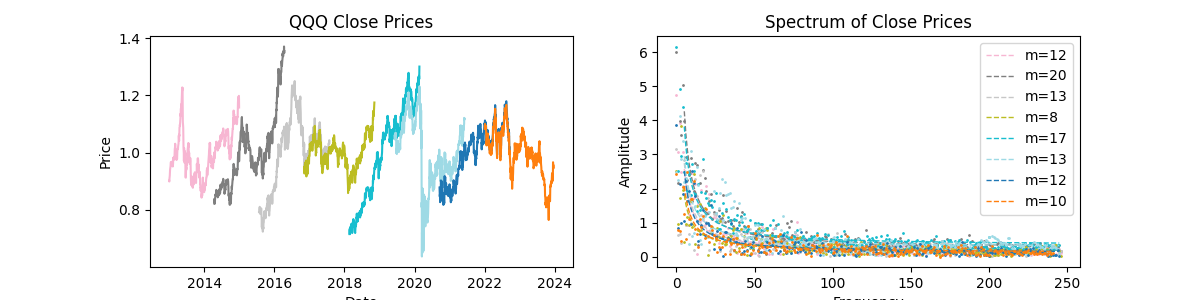

In [39]:
qqq = yf.Ticker("O")

start_dates = pd.date_range(start='2013-01-01', end='2022-01-01', periods=8)

fig, axs = plt.subplots(1, 2, figsize=(12,3))

# axs = [0, axs]

for start_date in start_dates:
    color = plt.cm.tab20(start_date.year % 20)

    start_date = start_date.replace(nanosecond=0)
    end_date = start_date + pd.DateOffset(years=2)

    qqq_data = qqq.history(start=start_date, end=end_date)
    qqq_df = pd.DataFrame(qqq_data)
    close_prices = qqq_df['Close']

    close_prices = close_prices / close_prices.mean()

    axs[0].plot(close_prices, color=color)
    axs[0].set_title('QQQ Close Prices')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Price')

    spectrum = np.fft.fft(close_prices)[10:]
    nyquist_freq = len(spectrum) // 2

    phase = np.angle(spectrum[1])
    print(np.abs(spectrum[1]) * (phase))


    def inverse_shift(x, m, b):
        return m/x + b
    min_freq = 5
    x = np.arange(min_freq, nyquist_freq)
    popt, pcov = curve_fit(inverse_shift, x, np.abs(spectrum[min_freq:nyquist_freq]))
    (m,b) = popt
    y = m/x + b

    axs[1].plot(np.abs(spectrum[:nyquist_freq]), '.', color=color, markersize=2)
    axs[1].plot(x, y, color=color, linestyle='--', label=f"m={round(m)}", linewidth=1)
    axs[1].legend()
    axs[1].set_title('Spectrum of Close Prices')
    axs[1].set_xlabel('Frequency')
    axs[1].set_ylabel('Amplitude')
    # axs[1].set_xscale('log')
    # axs[1].set_yscale('log')


-0.1198902367770629
0.5590338066332377
1.9193897797653339
2.0160007030072506
3.6882391132436285
0.9931879182405727
-1.5202161406360128
-2.337980611978861


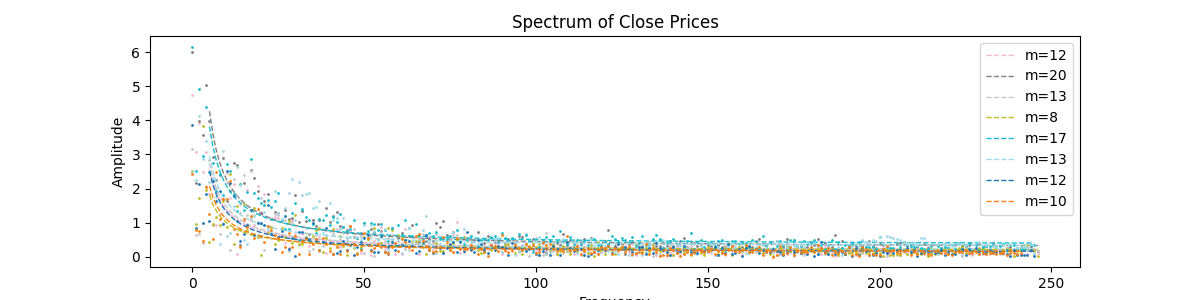

In [40]:
qqq = yf.Ticker("O")

start_dates = pd.date_range(start='2013-01-01', end='2022-01-01', periods=8)

fig, axs = plt.subplots(1, 1, figsize=(12,3))

axs = [0, axs]

for start_date in start_dates:
    color = plt.cm.tab20(start_date.year % 20)

    start_date = start_date.replace(nanosecond=0)
    end_date = start_date + pd.DateOffset(years=2)

    qqq_data = qqq.history(start=start_date, end=end_date)
    qqq_df = pd.DataFrame(qqq_data)
    close_prices = qqq_df['Close']

    close_prices = close_prices / close_prices.mean()

    spectrum = np.fft.fft(close_prices)[10:]
    nyquist_freq = len(spectrum) // 2

    phase = np.angle(spectrum[1])
    print(np.abs(spectrum[1]) * (phase))


    def inverse_shift(x, m, b):
        return m/x + b
    min_freq = 5
    x = np.arange(min_freq, nyquist_freq)
    popt, pcov = curve_fit(inverse_shift, x, np.abs(spectrum[min_freq:nyquist_freq]))
    (m,b) = popt
    y = m/x + b

    axs[1].plot(np.abs(spectrum[:nyquist_freq]), '.', color=color, markersize=2)
    axs[1].plot(x, y, color=color, linestyle='--', label=f"m={round(m)}", linewidth=1)
    axs[1].legend()
    axs[1].set_title('Spectrum of Close Prices')
    axs[1].set_xlabel('Frequency')
    axs[1].set_ylabel('Amplitude')
    # axs[1].set_yscale('log')
    # axs[1].set_xscale('log')
    # axs[1].set_yscale('log')


3.215671739310231
0.3952041896286383
0.8146119828289534
6.80369156766186
2.743148922207576
2.5615961314332636
4.802033131580606
0.33142051358610497


O: Data doesn't exist for startDate = 472366800, endDate = 535438800


ValueError: Invalid number of FFT data points (0) specified.

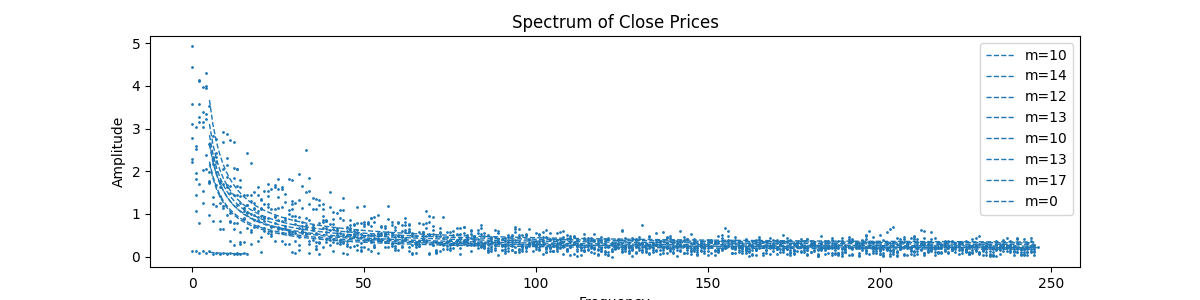

In [46]:
qqq = yf.Ticker("O")

# start_date = 
# start_date = 
end_date = pd.to_datetime("2022-12-20").replace(nanosecond=0)

fig, axs = plt.subplots(1, 1, figsize=(12,3))

axs = [0, axs]

color = plt.cm.tab20(start_date.year % 20)

for i in range(10):
    start_date = end_date - pd.DateOffset(years=2+i)
    end_date = end_date - pd.DateOffset(years=0+i)

    qqq_data = qqq.history(start=start_date, end=end_date)
    qqq_df = pd.DataFrame(qqq_data)
    close_prices = qqq_df['Close']

    close_prices = close_prices / close_prices.mean()

    spectrum = np.fft.fft(close_prices)[10:]
    nyquist_freq = len(spectrum) // 2

    phase = np.angle(spectrum[1])
    print(np.abs(spectrum[1]) * (phase))


    def inverse_shift(x, m, b):
        return m/x + b
    min_freq = 5
    x = np.arange(min_freq, nyquist_freq)
    popt, pcov = curve_fit(inverse_shift, x, np.abs(spectrum[min_freq:nyquist_freq]))
    (m,b) = popt
    y = m/x + b

    axs[1].plot(np.abs(spectrum[:nyquist_freq]), '.', color=color, markersize=2)
    axs[1].plot(x, y, color=color, linestyle='--', label=f"m={round(m)}", linewidth=1)
    axs[1].legend()
    axs[1].set_title('Spectrum of Close Prices')
    axs[1].set_xlabel('Frequency')
    axs[1].set_ylabel('Amplitude')
# axs[1].set_yscale('log')
# axs[1].set_xscale('log')
# axs[1].set_yscale('log')
